In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shwetanktripathi","key":"2ddac6c03f5c7a781207a3836a688770"}'}

In [2]:
# Install Kaggle API
!pip install kaggle

# Make directory for Kaggle configuration
!mkdir -p ~/.kaggle

# Move kaggle.json into the folder
!cp kaggle.json ~/.kaggle/

# Change permissions
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# List datasets available (optional)
!kaggle datasets list -s plantvillage

# Download the dataset
!kaggle datasets download -d 'emmarex/plantdisease'

# Unzip the dataset
!unzip plantdisease.zip -d plant_disease_dataset

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf__

Epoch 1/10
Training Loss: 0.0007 Validation Loss: 0.2276 Validation Accuracy: 0.9295
Epoch 2/10
Training Loss: 0.0005 Validation Loss: 0.1430 Validation Accuracy: 0.9530
Epoch 3/10
Training Loss: 0.0004 Validation Loss: 0.1211 Validation Accuracy: 0.9578
Epoch 4/10
Training Loss: 0.0002 Validation Loss: 0.0945 Validation Accuracy: 0.9700
Epoch 5/10
Training Loss: 0.0003 Validation Loss: 0.1003 Validation Accuracy: 0.9678
Epoch 6/10
Training Loss: 0.0001 Validation Loss: 0.0823 Validation Accuracy: 0.9724
Epoch 7/10
Training Loss: 0.0002 Validation Loss: 0.0719 Validation Accuracy: 0.9763
Epoch 8/10
Training Loss: 0.0002 Validation Loss: 0.0617 Validation Accuracy: 0.9796
Epoch 9/10
Training Loss: 0.0006 Validation Loss: 0.0655 Validation Accuracy: 0.9782
Epoch 10/10
Training Loss: 0.0000 Validation Loss: 0.0624 Validation Accuracy: 0.9787


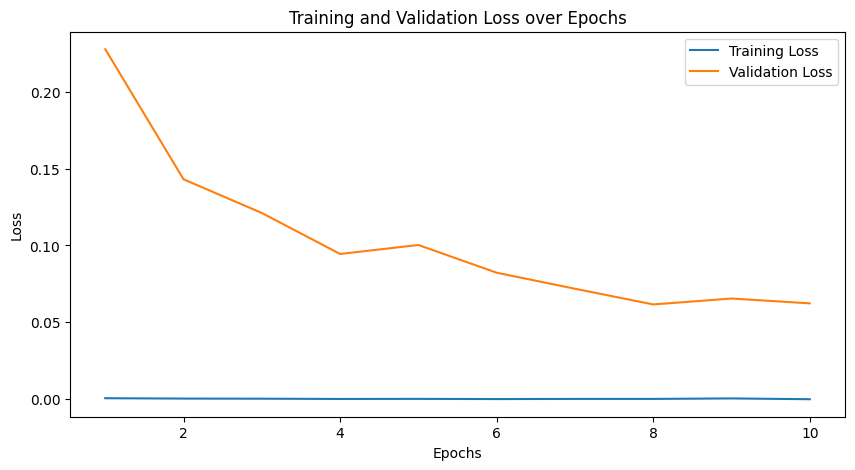

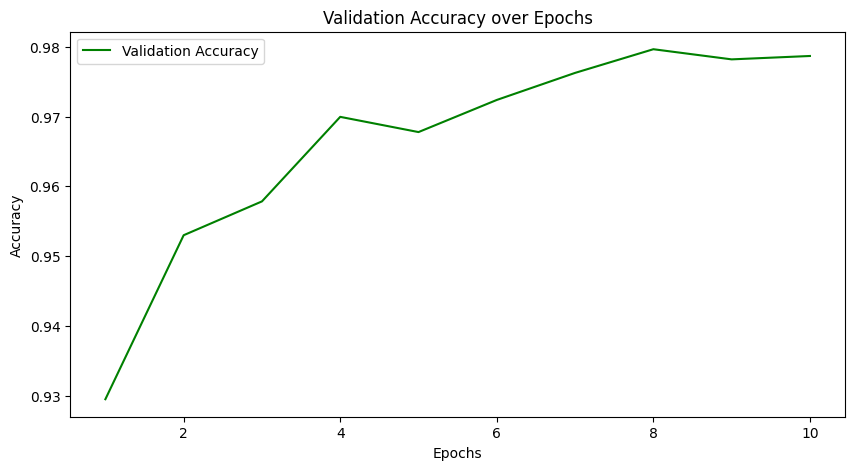

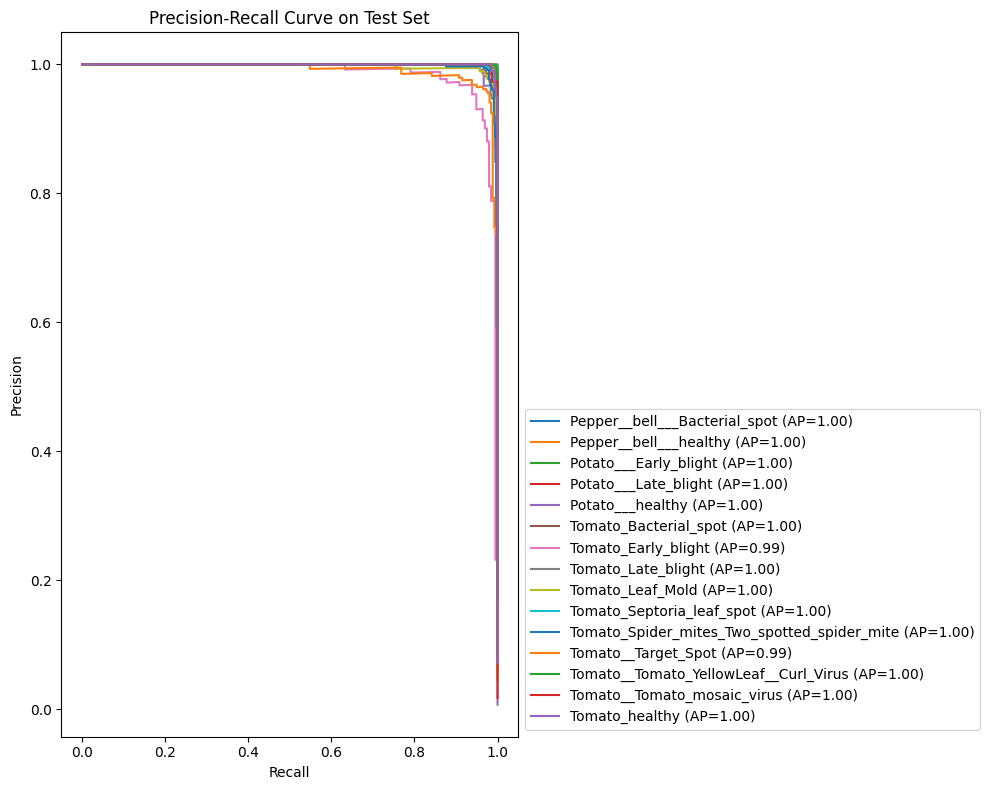

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import os

def main():
    # Directory containing all the data with class subdirectories
    data_dir = 'plant_disease_dataset/PlantVillage'  # Update with your actual path

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data transformations
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load the entire dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

    # Split the dataset into train (60%), val (20%), test (20%)
    dataset_size = len(full_dataset)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Set random seed for reproducibility
    torch.manual_seed(42)

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Data loaders
    batch_size = 32
    num_workers = 2  # Reduce if limited resources
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load a pre-trained model and fine-tune
    import torchvision.models as models
    from torchvision.models import ResNet50_Weights

    # Load the pre-trained ResNet50 model with the default weights
    weights = ResNet50_Weights.IMAGENET1K_V2  # Use the latest weights
    model = models.resnet50(weights=weights)

    num_classes = len(full_dataset.classes)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last few layers
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Include all trainable parameters in the optimizer
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

    # Learning rate scheduler
    from torch.optim.lr_scheduler import StepLR
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    # Training parameters
    epochs = 10  # Increased epochs
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Calculate training loss (optional)
        running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)

        # Validation step
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_dataset)
        val_acc = val_running_corrects.double() / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {epoch_loss:.4f} Validation Loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    # Evaluate on test set and plot PR curves
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute Precision-Recall curve and Average Precision for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        y_true = (all_labels == i).astype(int)
        y_scores = all_probs[:, i]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        average_precision = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f'{full_dataset.classes[i]} (AP={average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve on Test Set')
    plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0))
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()